# 1. 参数的更新

神经网络的学习的目的是找到使损失函数的值尽可能小的参数。这是寻找最优参数的问题，解决这个问题的过程称为 **最优化**（optimization）。遗憾的是，神经网络的最优化问题非常难。这是因为参数空间非常复杂，无法轻易找到最优解。而且，在深度神经网络中，参数的数量非常庞大，导致最优化问题更加复杂。

## 1.1 SGD

随机梯度下降法（Stochastic Gradient Descent，SGD）是一般机器学习中应用最多的优化算法，特别是在深度学习中。按照数据生成分布抽取 m 个小批量（独立同分布的）样本，通过计算它们的梯度均值，我们可以得到梯度的无偏估计。SGD 是一个简单的方法，不过比起胡乱地搜索参数空间，也算是“聪明”的方法。

$$ W = W - \eta g $$

这里把需要更新的权重参数记为 $W$，把损失函数 $L$ 关于 $W$ 的梯度记为 $g = \frac{\partial L}{\partial W}$。$\eta$ 表示学习率（learning rate），之前实践中，所使用的都是固定的学习率。若学习率太大，学习曲线会剧烈震荡；相反，如果学习率太小，学习过程会很缓慢，可能会卡在一个相当高的代价值。

### 学习率衰减（learning rate decay）

在实践中，有必要随着时间的推移逐渐降低学习率，一般会线性衰减学习率直到第n次迭代：

$$ \eta_k = (1 - \alpha)\eta_0 + \alpha \eta_n $$

其中 $ \alpha = \frac{k}{n}$，通常 $ \eta_n $ 应设为大约 $\eta_0$的 1%。

现在，我们将 SGD 算法实现为一个名为 SGD 的 Python 类，

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

进行初始化时的参数 lr 表示学习率。代码段中还定义了update(params, grads)方法，这个方法在SGD中会被反复调用。参数 params 和 grads（与之前的神经网络的实现一样）是字典型变量，按 params['W1']、grads['W1'] 的形式，分别保存了权重参数和它们的梯度。

可以按如下方式进行神经网络的参数的更新：

```python
network = TwoLayerNet(...)
optimizer = SGD()    # 优化器对象

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # mini-batch
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

虽然SGD简单容易实现，但是在解决某些问题时可能没有效率。这里思考一下求下面这个函数的最小值的问题。

$$ f(x, y) = \frac{1}{20}x^2 + y^2 \tag{$1$} $$

这个函数梯度的特征是，y 轴方向上大，x 轴方向上小。我们尝试对该函数应用 SGD，从 $(x,y)=(-7, 2)$ 初始点开始搜索，如下图所示，搜索路径呈“之”字形移动。

![img](images/chapter12/SGD.png)

SGD低效的根本原因是，梯度的方向并没有指向最小值的方向。为了改正 SGD 的缺点，下面我们将介绍 Momentum、AdaGrad、Adam 这三种方法来取代SGD。

## 1.2 动量(Momentum)

虽然 SGD 仍然是非常受欢迎的优化方法，但其学习过程有时会很慢。动量方法旨在加速学习，特别是处理小但一致的梯度，或是带噪声的梯度。动量算法积累了之前梯度指数级衰减的移动平均，并且继续沿该方向移动。

动量方法表示如下：
$$ v = \alpha v - \eta g $$
$$ W = W + v $$

之前步长只是梯度乘以学习率，现在步长取决于梯度序列的大小和排列。当许多连续的梯度指向相同的方向时，步长最大。如果动量算法总是观测到梯度 g，那么它会不停加速，直到达到最终速度，其中步长大小为

$$ v_{(n)} =  \alpha^n v_{(0)} -\frac{1-\alpha^n}{1-\alpha}\cdot \eta g \approx -\frac{\eta}{1-\alpha}\cdot g $$

因此将动量的超参数视为 $\frac{1}{1-\alpha}$ 有助于理解。例如，$\alpha = 0.9$ 对应着最大速度10倍于梯度下降算法。和学习率一样，$\alpha$ 也会随着时间不段调整，一般初始值是一个较小的值，随后慢慢变大。

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

和 SGD 的情形相比，动量方法可以更快地朝 x 轴方向靠近，减弱“之”字形的变动程度。这是因为虽然 x 轴方向上受到的力非常小，但是一直在同一方向上受力，所以朝同一个方向会有一定的加速。相反，虽然 y 轴方向上受到的力很大，但是因为交互地受到正方向和反方向的力，它们会互相抵消。

![img](images/chapter12/momentum.png)

## 1.3 AdaGrad (AdaptiveGradient)

学习率衰减的想法，相当于将“全体”参数的学习率值一起降低。AdaGrad 进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习。算法如下：

$$ h = h + g^2 $$
$$ W = W - \frac{\eta}{\sqrt {h}} g$$

变量 $h$ 保存了以前所有梯度值的平方和。在更新参数时，通过乘以 $\frac{1}{\sqrt h}$，就可以调整学习的尺度，相当于加了一个约束项 $ \frac{1}{\sqrt{\sum_1^t g_{(t)}^2}} $。

- 当前期 $g$ 较小的时候，约束项较大，能放大梯度；

- 当后期 $g$ 较大的时候，约束项较小，能约束梯度。

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

需要注意的是，最后一行加上了微小值 1e-7，这是为了防止当 self.h[key] 中出现 0 时的情况。

使用AdaGrad解决式（1）的最优化问题，结果如图所示：

![img](images/chapter12/AdaGrad.png)

由图结果可知，函数的取值高效地向着最小值移动。由于 y 轴方向上的梯度较大，因此刚开始变动较大，但是后面会根据这个较大的变动按比例进行调整，减小更新的步伐。因此，y 轴方向上的更新程度被减弱，“之”字形的变动程度有所衰减。

## 1.4 RMSProp

RMSProp算法修改AdaGrad 以在非凸情况下效果更好。当应用于非凸函数训练神经网络时，学习轨迹可能需要穿过了很多不同的结构，最终到达一个局部是碗状的区域。AdaGrad根据平方梯度的整个历史收缩学习率，可能使得学习率在达到这样的凸结构前就变得太小了。RMSProp使用指数衰减平均以丢弃遥远过去的历史梯度，使其能够在找到凸碗状结构后快速收敛，它就像一个初始化于该碗状结构的AdaGrad 算法实例。算法如下：

$$ h = \rho h + (1 - \rho) g^2 $$
$$ W = W - \frac{\eta}{\sqrt {h}} g$$

In [4]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

## 1.5 [Adam](https://arxiv.org/abs/1412.6980v8)

Adam (**Ada**ptive **M**oments)是另一种学习率自适应的优化算法，它被看做是 RMSProp 和动量方法的结合。

首先，计算有偏一阶矩估计和有偏二阶矩估计：

$$ m = \beta_1 m + (1-\beta_1) g $$
$$ v = \beta_2 v + (1-\beta_2) g^2 $$

然后，修正矩估计的偏差：

$$ \hat m = \frac{m}{1-\beta_1^t} $$
$$ \hat v = \frac{v}{1-\beta_2^t} $$

最后，计算更新：

$$ W = W - \frac{\eta \hat m}{\sqrt {\hat v}} $$

In [5]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            
            unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            params[key] -= self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

上面我们介绍了 SGD、Momentum、AdaGrad、Adam 几种方法，那么用哪种方法好呢？非常遗憾，（目前）并不存在能在所有问题中都表现良好的方法。这几种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。虽然具有自适应学习率的算法（如 RMSProp）表现得相当鲁棒，但没有哪个算法能脱颖而出。

选择哪一个算法似乎主要取决于使用者对算法的熟悉程序，以便调节超参数。

# 2. 权重的初始值

在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，往往关系到神经网络的学习能否成功。

## 2.1 可以将权重初始值设为0吗

严格地说，为什么不能将权重初始值设成一样的值呢？

这是因为在误差反向传播法中，所有的权重值都会进行
相同的更新。比如，在 2 层神经网络中，假设第 1 层和第 2 层的权重为0。这样一来，正向传播时，因为输入层的权重为 0，所以第 2 层的神经元全部会被传递相同的值。第 2 层的神经元中全部输入相同的值，这意味着反向传播时第 2 层的权重全部都会进行相同的更新。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。这使得神经网络拥有许多不同的权重的意义丧失了。

为了防止“权重均一化”（严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

# 2.2 隐藏层的激活值的分布

观察隐藏层的激活值（激活函数的输出数据）的分布，可以获得很多启发。这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的激活值的分布的。

这里假设神经网络有 5 层，每层都含有 100 个神经元。然后，用正态分布随机生成 1000 个数据作为输入数据，并把它们传给 5 层神经网络。激活函数使用sigmoid 函数，各层的激活值的结果保存在 activations 字典变量中。最后，使用直方图绘制各层激活值的数据分布。

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

In [7]:
def draw_output(w, activation_func):
    # 随机生成200个数据
    input_data = np.random.randn(200, 100)
    # 5层隐藏层
    hidden_layer_size = 5
    activations = {}  # 用来保存激活值的结果

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        activations[i] = activation_func(a)

    # 绘制直方图
    plt.figure(figsize=(12, 4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0:
            plt.yticks([], []) # 不显示y轴刻度
        plt.ylim(0, 2000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

起初，我们使用的是标准差为 1 的正态分布初始化权重。

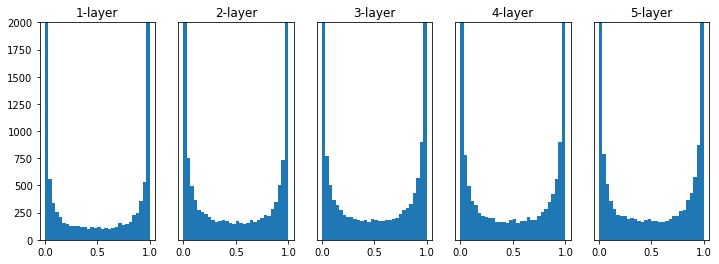

In [8]:
# 各隐藏层的神经元数为100
node_num = 100
w = np.random.randn(node_num, node_num)
draw_output(w, sigmoid)

各层的激活值呈偏向 0 和 1 的分布。这里使用的 sigmoid 函数随着输出不断地靠近 0（或者靠近1），它的导数的值逐渐接近 0。因此，偏向 0 和 1 的数据分布会造成反向传播中梯度的值不断变小，最后消失，这也叫做 sigmoid 函数的**饱和现象**。这个问题称为 **梯度消失**（gradient vanishing）问题。层次加深的深度学习中，梯度消失的问题可能会更加严重。

下面，将权重的标准差设为 0.01，进行相同的实验。

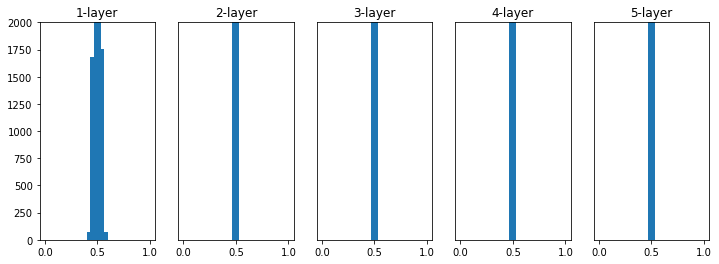

In [9]:
# 改变权重初始值的标准差为0.01
w = np.random.randn(node_num, node_num) * 0.01
draw_output(w, sigmoid)

这次数值呈集中在 0.5 附近的分布。因为不像刚才的例子那样偏向 0 和 1，所以不会发生梯度消失的问题。

但是，激活值的分布有所偏向，说明在表现力上会有很大问题。因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。例如，如果 100 个神经元都输出几乎相同的值，那么也可以由 1 个神经元来表达基本相同的事情。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

如果我们将权重的标准差设为 0.1，再次进行实验，会发现输出数值集中的情况改善许多。

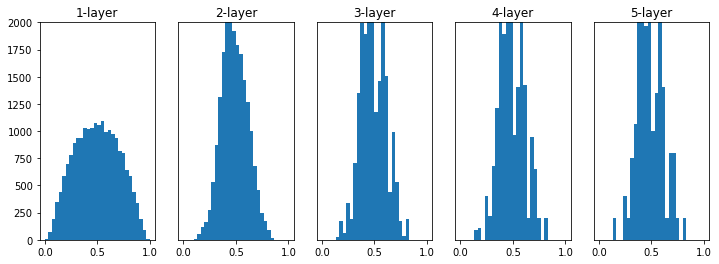

In [10]:
# 改变权重初始值的标准差为0.1
w = np.random.randn(node_num, node_num) * 0.1
draw_output(w, sigmoid)

接着，我们尝试使用 **Xavier Glorot**，**Yoshua Bengio** 的论文 [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html) 中推荐的权重初始值（俗称“Xavier 初始值”）。

考察第 $j+1$ 层神经元节点 $z$，前向传播时 $ z = \sum_{i=1}^{n_j} w_ix_i $，其中 $n_{j}$ 为第 $j$ 层神经元的数量。根据两个随机变量乘积的方差展开式：

$$ {\rm Var}(w_i x_i) = E[w_i]^2{\rm Var}(x_i) + E[x_i]^2{\rm Var}(w_i) + {\rm Var}(w_i){\rm Var}(x_i) $$

我们可以令 $E[x_i]=0$， $E[w_i]=0$，则有
$$ {\rm Var}(w_i x_i) = {\rm Var}(w_i){\rm Var}(x_i) $$
$$ {\rm Var}(z) = \sum_{i=1}^{n_j} {\rm Var}(w_i){\rm Var}(x_i) $$

如果随机变量 $x_i$ 和 $w_i$ 满足独立同分布的话：
$$ {\rm Var}(z) = n_{j}{\rm Var}(W){\rm Var}(X) $$

为了让样本空间与类别空间的分布差异不要太大，也就是要让它们的方差尽可能相等，即 ${\rm Var}(z)={\rm Var}(X)$，则
$$ {\rm Var}(W) = \frac{1}{n_j}$$

同样，反向传播时是从后往前计算的，因此 $${\rm Var}(W)=\frac{1}{n_{j+1}}$$ 

实际中，常取输入和输出神经元个数平均值，即
$${\rm Var}(W)=\frac{2}{n_{j} + n_{j+1}}$$ 

假设 $W$ 为均匀分布的话，由 $W$ 在区间 $[a,b]$ 内均匀分布时的方差为
$$ {\rm Var}(W)= \frac{(b-a)^2}{12} $$

综上，初始值满足下面范围内的均匀分布：

$$ W \sim U[-\frac{\sqrt{6}}{\sqrt{n_j+n_{j+1}}}, \frac{\sqrt{6}}{\sqrt{n_j+n_{j+1}}}] $$

其中，$U$ 代表均匀分布，$n_j$ 为第 $j$ 层神经元个数。

现在，在一般的深度学习框架中，Xavier 初始值已被作为标准使用。

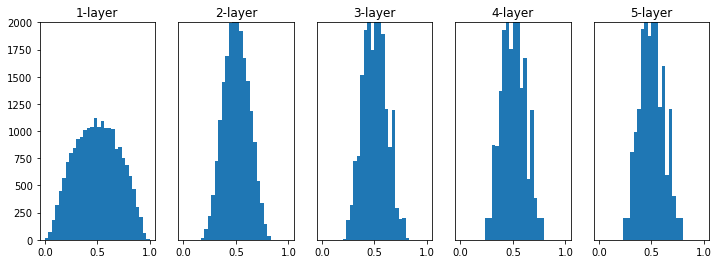

In [11]:
# uniform distribution
w = np.random.uniform(-np.sqrt(6.0/200), np.sqrt(6.0/200), (node_num, node_num))
draw_output(w, sigmoid)

还有一种简化的 Xavier 实现方式是，只使用了前一层的输入节点进行计算。如果前一层的节点数为n，则权重初始值使用标准差为 $\frac{1}{\sqrt{n}}$ 的正态分布。

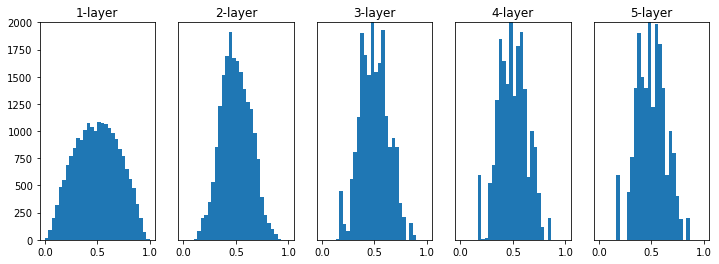

In [12]:
# normal distribution
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w, sigmoid)

## 2.3 ReLU的权重初始值

Xavier 初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适合使用Xavier 初始值。

但当激活函数使用 ReLU 时，一般推荐使用 ReLU 专用的初始值，也就是 Kaiming He 等人推荐的初始值，也称为“He初始值”。当前一层的节点数为 n 时，He 初始值使用标准差为的高斯分布。当 Xavier 初始值是时，（直观上）可以解释为，因为ReLU的负值区域的值为0，为了使它更有广度，所以需要 2 倍的系数。

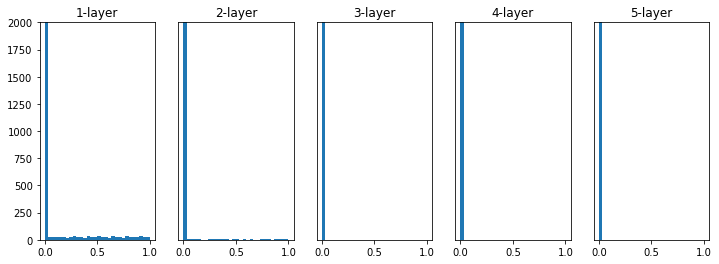

In [13]:
w = np.random.randn(node_num, node_num)
draw_output(w, ReLU)

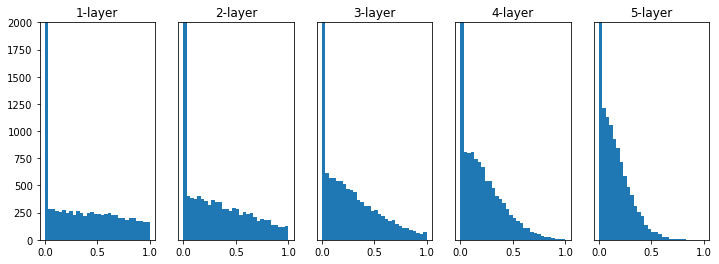

In [14]:
# Xavier initialization
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
draw_output(w, ReLU)

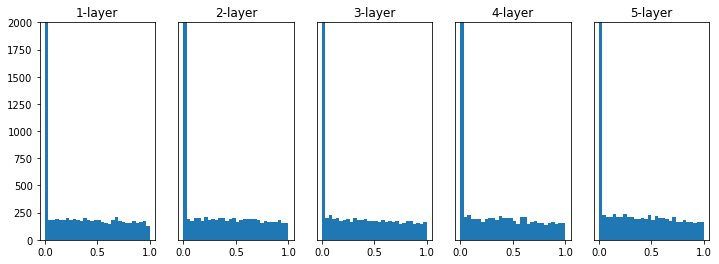

In [15]:
# He initialization
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
draw_output(w, ReLU)

观察实验结果可知，当“std = 0.01”时，各层的激活值非常小。神经网络上传递的是非常小的值，说明逆向传播时权重的梯度也同样很小。这是很严重的问题，实际上学习基本上没有进展。

Xavier 初始值时的情况下，随着层的加深，偏向一点点变大，学习时会出现梯度消失的问题。而当初始值为 He 初始值时，各层中分布的广度相同。由于即便层加深，数据的广度也能保持不变，因此逆向传播时，也会传递合适的值。

总结一下，当激活函数使用 ReLU 时，权重初始值使用He初始值，当激活函数为 sigmoid 或 tanh 等 S 型曲线函数时，初始值使用 Xavier 初始值。

## 2.4 基于MNIST 数据集的权重初始值的比较

这个实验中，神经网络有 5 层，每层有 100 个神经元，激活函数使用的是 ReLU。

Using TensorFlow backend.


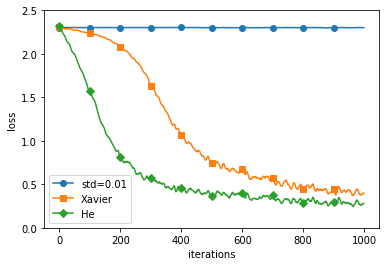

In [16]:
from keras.datasets import mnist
from demo_code.multi_layer_net import MultiLayerNet
from demo_code.util import smooth_curve

# 读入MNIST数据
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype(np.float32) / 255.0      # Normalization
test_images = test_images.astype(np.float32) / 255.0      # Normalization

train_size = train_images.shape[0]
batch_size = 128
max_iterations = 1000


# 进行实验参数设置
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 开始训练
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_images[batch_mask]
    t_batch = train_labels[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

# 绘制图形
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

从结果可知，std = 0.01 时完全无法进行学习。这和刚才观察到的激活值的分布一样，是因为正向传播中传递的值很小（集中在 0 附近的数据）。因此，逆向传播时求到的梯度也很小，权重几乎不进行更新。相反，当权重初始值为Xavier 初始值和 He 初始值时，学习进行得很顺利，并且采用 He 初始值时的学习速度更快一些。

综上，在神经网络的学习中，权重初始值非常重要，很多时候权重初始值的设定关系到神经网络的学习能否成功。

# 3. [Batch Normalization](https://arxiv.org/abs/1502.03167)

Batch Normalization 由 Ioffe 和 Szegedy 于 2015 年提出，算法的思路是调整各层的激活值分布使其拥有适当的广度。算法以进行学习时的 mini-batch 为单位进行正规化，使数据分布的均值为 0、方差为 1。如下所示，

$$ \mu_B \leftarrow \frac{1}{m} \sum_{i=1}^m{x_i} $$
$$ \sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^m{(x_i-\mu_B)^2} $$
$$ \hat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} $$

针对 mini-batch 的 m 个输入数据的集合 $B = \{x_1, x_2, . . . , x_m\}$ 求均值 $\mu_B$ 和方差 $\sigma_B^2$。然后，对输入数据进行均值为 0、方差为 1（合适的分布）的正规化。$\epsilon$ 是一个微小值（例如，10e-7），它是为了防止出现除以 0 的情况。

接着，Batch Norm 层会对正规化后的数据进行缩放和平移变换，表示如下：

$$ y_i \leftarrow \gamma \hat x_i + \beta $$

其中，$\gamma$ 和 $\beta$ 是可学习参数，初始值 $\gamma=1$， $\beta=0$

下图是权重初始值的标准差为各种不同的值时的学习过程图。几乎所有的情况下都是使用Batch Norm时学习进行得更快。同时也可以发现，实际上，在不使用Batch Norm 的情况下，如果不赋予一个尺度好的初始值，学习将完全无法进行。

![img](images/chapter12/batch_norm.png)

总结：

- 可以使学习快速进行（可以增大学习率）
- 对于初始值选取不用那么敏感
- 抑制过拟合（降低Dropout等的必要性）

* Yuxin Wu, Kaiming He 于2018年提出了 [Group Normalization](https://arxiv.org/abs/1803.08494)，沿 channel 方向分 group 计算均值和方差，不会受到 batch_size 大小的影响。

# 4. 正则化

机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机器学习的目标是提高泛化能力，即便是没有包含在训练数据里的未观测数据，也希望模型可以进行正确的识别。我们可以制作复杂的、表现力强的模型，但是相应地，抑制过拟合的技巧也很重要。

## 4.1 过拟合

发生过拟合的原因，主要有以下两个：

- 模型拥有大量参数、表现力强
- 训练数据少

这里，我们故意满足这两个条件，制造过拟合现象。为此，要从 MNIST 数据集原本的 60000 个训练数据中只选定 200 个，并且，为了增加网络的复杂度，使用 7 层网络（每层有 100 个神经元，激活函数为 ReLU）。

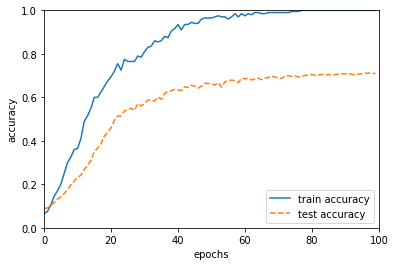

In [17]:
from keras.datasets import mnist
from demo_code.multi_layer_net import MultiLayerNet

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype(np.float32) / 255.0      # Normalization
test_images = test_images.astype(np.float32) / 255.0      # Normalization
# 为了过拟合，人为减少学习数据
train_images = train_images[:200]
train_labels = train_labels[:200]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 用学习率为0.01的SGD更新参数
max_epochs = 100
train_size = train_images.shape[0]
batch_size = 50
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(int(iter_per_epoch) * max_epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    images_batch = train_images[batch_mask]
    labels_batch = train_labels[batch_mask]
    
    grads = network.gradient(images_batch, labels_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, label='train accuracy')
plt.plot(x, test_acc_list, linestyle="--", label='test accuracy')
plt.xlim(0, max_epochs)
plt.ylim(0, 1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

在 80 个 epoch 左右后，用训练数据测量到的识别精度几乎都为 100%。但是，对于测试数据，离 100% 的识别精度还有较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。从图中可知，模型对训练时没有使用的一般数据（测试数据）拟合得不好。

## 4.2 权值衰减

权值衰减是一直以来经常被使用的一种抑制过拟合的方法。很多过拟合原本就是因为权重参数取值过大才发生的，该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。

为损失函数加上权重的平方范数（L2 范数），就可以抑制权重变大。将权重记为 $W$，L2 范数的权值衰减就是 $\frac{1}{2}\lambda W^2$，然后将这个$\frac{1}{2}\lambda W^2$ 加到损失函数上。这里，$\lambda$ 是控制正则化强度的超参数。$\lambda$ 设置得越大，对大的权重施加的惩罚就越重。

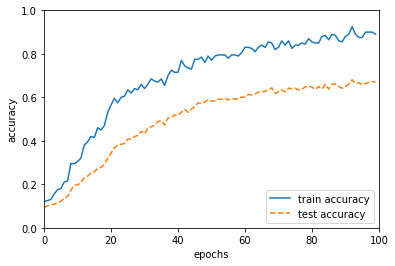

In [18]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                        output_size=10, weight_decay_lambda=0.1)
train_acc_list = []
test_acc_list = []

for i in range(int(iter_per_epoch) * max_epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    images_batch = train_images[batch_mask]
    labels_batch = train_labels[batch_mask]
    
    grads = network.gradient(images_batch, labels_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_images, train_labels)
        test_acc = network.accuracy(test_images, test_labels)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
plt.plot(x, train_acc_list, label='train accuracy')
plt.plot(x, test_acc_list, linestyle="--", label='test accuracy')
plt.xlim(0, max_epochs)
plt.ylim(0, 1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

虽然训练数据的识别精度和测试数据的识别精度之间有差距，但是与没有使用权值衰减的结果相比，差距变小了。此外，训练数据的识别精度没有达到 100%。这说明过拟合受到了抑制。

## 4.3 [Dropout](http://jmlr.org/papers/v15/srivastava14a.html)

Dropout 是一种在学习的过程中随机删除神经元的方法。训练时，随机选出隐藏层的神经元，然后将其删除，被删除的神经元不再进行信号的传递。每传递一次数据，就会随机选择要删除的神经元。测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出，要乘上训练时的删除比例后再输出。

![img](images/chapter12/dropout.png)

In [19]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

机器学习中经常使用 **集成学习** (ensemble learning)。所谓集成学习是通过几个模型降低泛化误差的技术，其思想是让多个不同的模型单独进行学习，推理时再取多个模型的输出的平均值。用神经网络的语境来说，准备多个结构相同（或者类似）的网络分别进行学习，测试时以这几个网络的输出的平均值作为结果。

可以将 Dropout 理解为，通过在学习过程中随机删除神经元，从而每一次都让不同的模型进行学习。并且在推理时，通过对神经元的输出乘以删除比例，可以取得模型的平均值。也就是说，可以理解成，Dropout 将集成学习的效果（模拟地）通过一个网络实现了。

# 5. 超参数的验证

神经网络中，除了权重和偏置等参数，**超参数**（hyper-parameter）也经常出现。这里所说的超参数是指，比如各层的神经元数量、mini-batch 大小、参数更新时的学习率或权值衰减等。参数配置不同，学得模型的性能往往有显著差别。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中一般会伴随很多的试错。

## 5.1 验证集(validation set)

之前我们使用的数据集分成了训练数据和测试数据，训练数据用于学习，测试数据用于评估泛化能力。由此，就可以评估是否只过度拟合了训练数据（是否发生了过拟合），以及泛化能力如何等。

下面我们要对超参数设置各种各样的值以进行验证。这里要注意的是，*不能使用测试数据评估超参数的性能*。这一点非常重要，但也容易被忽视。

为什么不能用测试数据评估超参数的性能呢？这是因为如果使用测试数据调整超参数，超参数的值会对测试数据发生过拟合。换句话说，用测试数据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据。这样的话，可能就会得到不能拟合其他数据、泛化能力低的模型。

因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为 **验证数据**（validation data）。我们使用这个验证数据来评估超参数的好坏。

根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种情况下，用户需要自行进行分割。如果是 MNIST 数据集，获得验证数据的最简单的方法就是从训练数据中事先分割 20% 作为验证数据。

In [20]:
# 分割验证数据
validation_rate = 0.20
validation_num = int(train_images.shape[0] * validation_rate)

val_images = train_images[:validation_num]
val_labels = train_labels[:validation_num]
train_images = train_images[validation_num:]
train_labels = train_labels[validation_num:]

## 5.2 交叉验证(cross-validation)

交叉验证（cross-validation）是一种评估泛化性能的统计学方法，它比单次划分训练集和验证集的方法更加稳定、全面。在交叉验证中，数据被多次划分，并且需要训练多个模型。

最常用的交叉验证是 **k 折交叉验证**（k-fold cross-validation），其中 k 是由用户指定的数字，通常取 5 或 10。

![img](images/chapter12/cross_validation.png)

在执行 5 折交叉验证时，首先将数据划分为（大致）相等的5 部分，每一部分叫作**折**（fold）。接下来依次挑选其中一折作为测试集，其它折中的数据作为训练集，训练一系列模型。对于将数据划分为训练集和测试集的这 5 次划分，每一次都要计算精度。最后我们得到了5 个精度值。

### 交叉验证的优缺点

首先，对数据进行随机划分可能导致样本分布不均的情况。但使用交叉验证，每个样例都会刚好在测试集中出现一次：每个样例位于一个折中，而每个折都在测试集中出现一次。因此，模型需要对数据集中所有样本的泛化能力都很好，才能让所有的交叉验证得分（及其平均值）都很高。

其次，对数据进行多次划分，还可以提供我们的模型对训练集选择的敏感性信息。它告诉我们将模型应用于新数据时在最坏情况和最好情况下的可能表现。

交叉验证的主要缺点是增加了计算成本。现在我们要训练 k 个模型而不是单个模型，所以交叉验证的速度要比数据的单次划分大约慢 k 倍。

## 5.3 网格搜索

找到一个模型的重要参数（提供最佳泛化性能的参数）的取值是一项棘手的任务，但对于几乎所有模型和数据集来说都是必要的。其中最常用的方法就是 **网格搜索**（grid search），它主要是指尝试我们关心的参数的所有可能组合。